In [11]:
import matplotlib.pyplot as plt; plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import matplotlib as mpl
import pandas as pd
import librosa
import numpy as np
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import tqdm
import itertools
import scipy.stats
import random

import sys; sys.path.insert(0, '..')
from src.features import *

In [12]:
base_config = {
    # 'frame_size': [2**n for n in range(11, 16)],
    'frame_size': [2048],
    'hop_ratio': [1],
    # 'n_coeff': [10*i for i in range(4,10, 2)],
    'n_coeff': [100],
    'sr': [10000],
    'size': [60],
    'feature': ['MFCC_welch']
}

configs = [
{
    'clf': [sklearn.neighbors.KNeighborsClassifier()],
    # 'n_neighbors': [10*i+1 for i in range(4,10, 2)],
    'n_neighbors': [3],
    'p': [1],
    'weights': ['distance'], 
},
]

configs = [config | base_config for config in configs]
configs = sklearn.model_selection.ParameterGrid(configs)

In [14]:
features_df = pd.read_pickle('../data/processed/features_cnsm.pkl')
# features_df = features_df[features_df.player.isin(list(range(26)))]

def train(config, train_cdt, test_cdt):
    # Test / Train
    x_train = np.vstack(features_df[train_cdt.to_numpy()].features)
    y_train = features_df[train_cdt.to_numpy()].violin.to_numpy()
    x_test = np.vstack(features_df[test_cdt.to_numpy()].features)
    y_test = features_df[test_cdt.to_numpy()].violin.to_numpy()

    # Train
    estimator = config['clf']
    estimator.set_params(**config)
    pipeline = sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('knn', estimator),
    ])
    pipeline.fit(x_train, y_train)
    return pipeline.score(x_test, y_test)

In [50]:
names = list(set(features_df.player))


scores = []
for i in tqdm.tqdm(range(2, 13)):
    subsets = list(itertools.combinations(names, i))
    random.shuffle(subsets)
    for subset in subsets[:20]:
        train_cdt = features_df.player.isin(list(subset))
        test_cdt = features_df.violin.isin(['A', 'B', 'C'])
        if not train_cdt.sum(): continue
        if not test_cdt.sum(): continue
        score = train(configs[0], train_cdt, test_cdt)
        scores.append({'score': score, 'n': i})
scores = pd.DataFrame.from_dict(scores)

100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


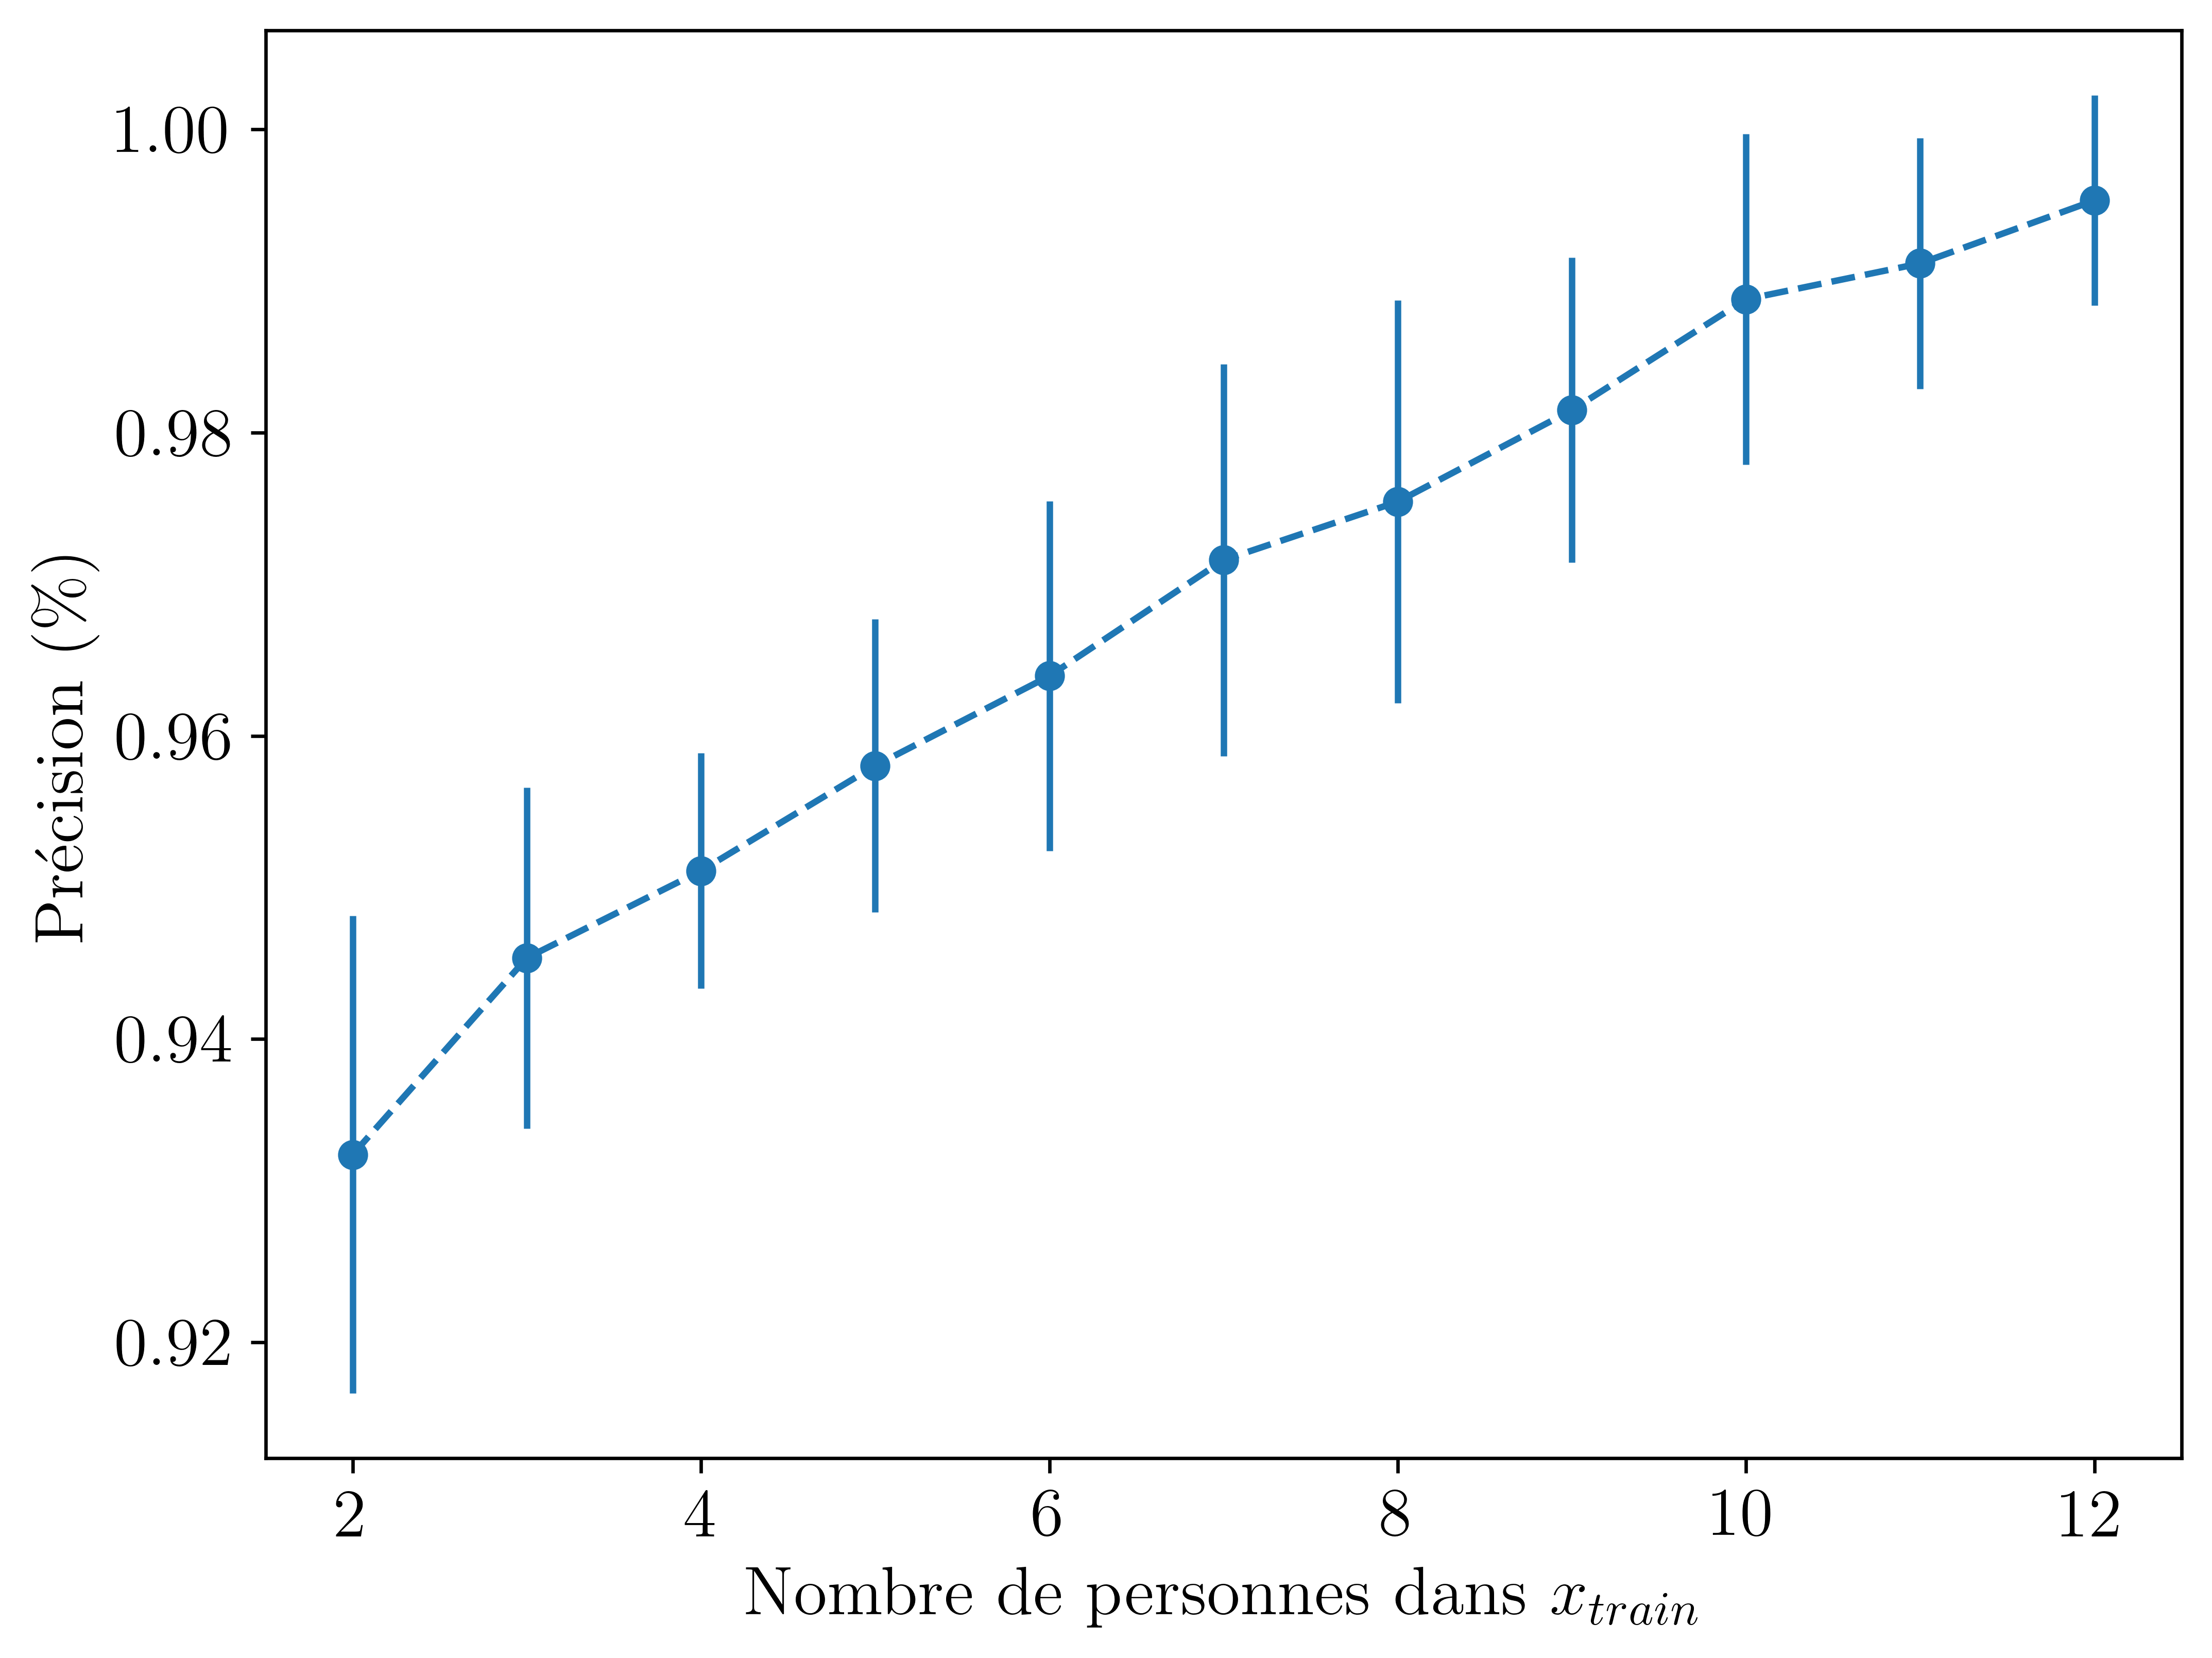

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
stats = scores.groupby('n')['score'].agg(['mean', 'std']).reset_index()
ax.errorbar(x='n', y='mean', yerr='std', data=stats, fmt='o--')
# plt.plot('n', 'score', '.', data=scores)
ax.set_xlabel('Nombre de personnes dans $x_{train}$')
ax.set_ylabel('Précision (\\%)')
plt.show()

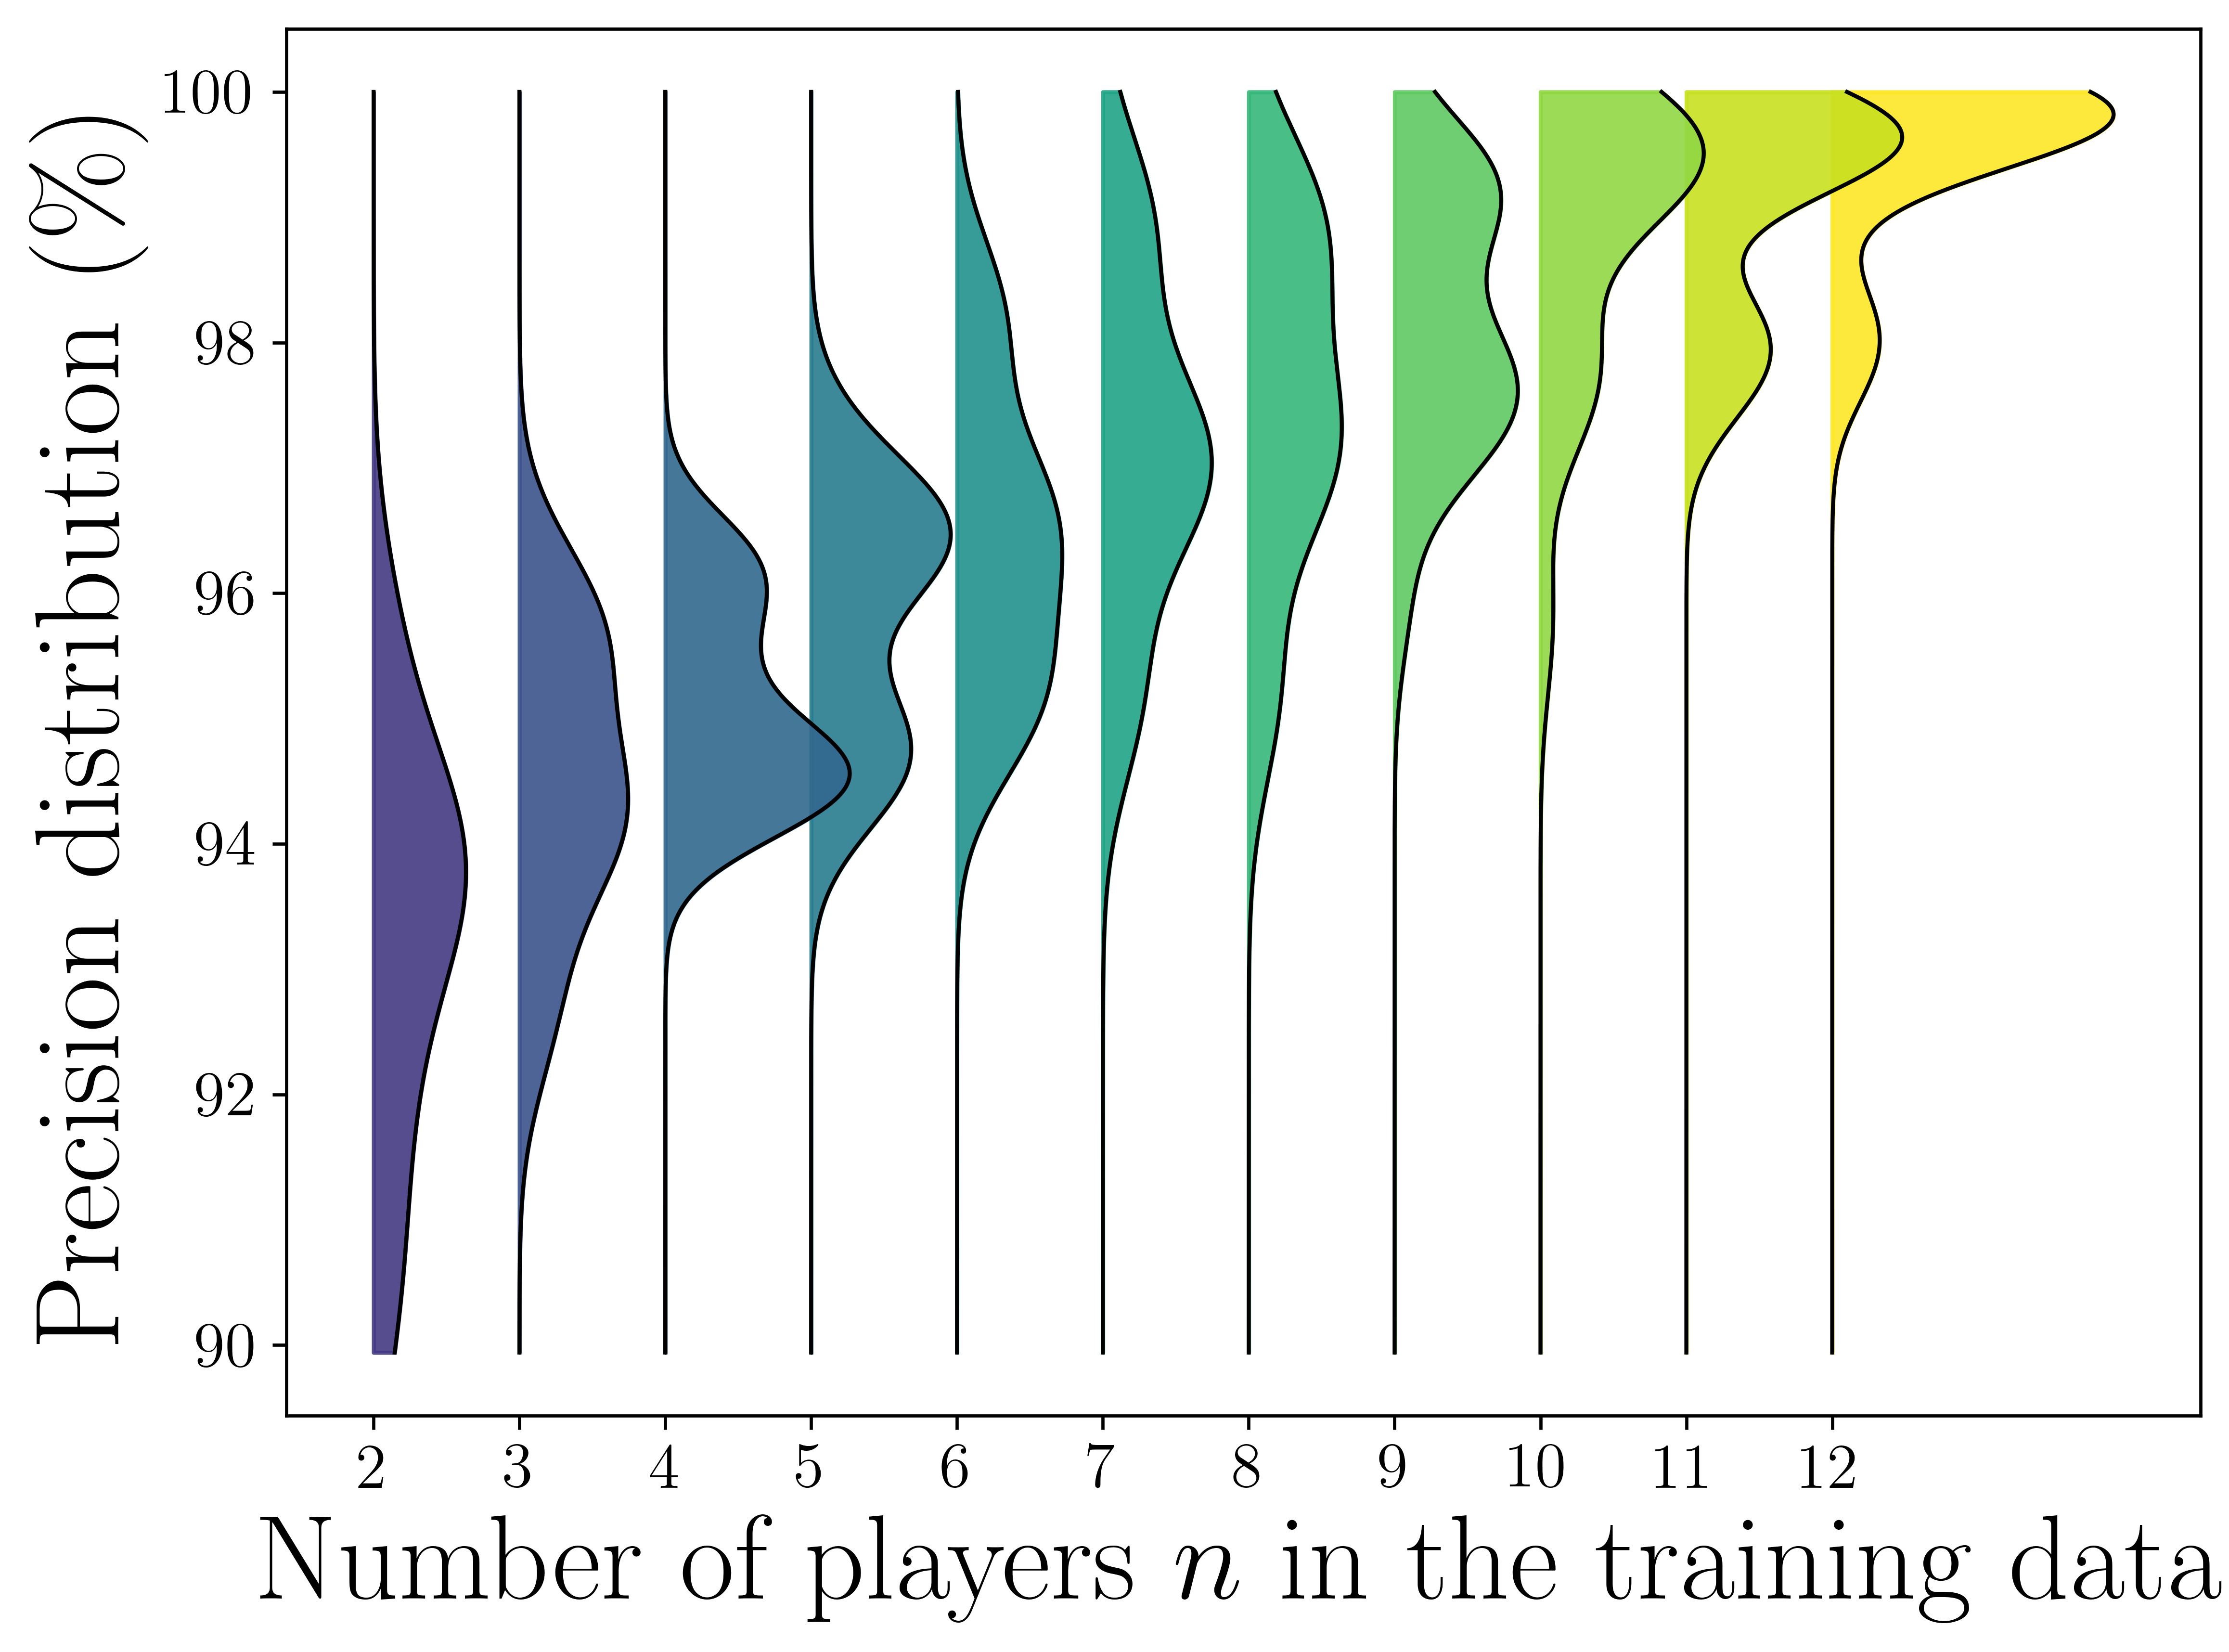

In [53]:
fig, ax = plt.subplots(figsize=(8,6))

n_points = 1000
overlap = 0.8

xs = []
y = np.linspace(
    scores['score'].min(),
    scores['score'].max(),
    n_points
)

for i in scores['n'].unique():
    pdf = scipy.stats.gaussian_kde(scores[scores['n'] == i].score)
    x = i * (1 - overlap)
    xs.append(x)
    ax.fill_betweenx(
        y*100, 
        np.ones(n_points) * x,
        pdf(y)/200 + x,
        alpha=.9,
        zorder=-i,
        color=mpl.colormaps['viridis'](i/12)
    )
    ax.plot(
        pdf(y)/200 + x,
        y*100,
        c='k',
        linewidth=1
    )
ax.set_xticks(xs, scores['n'].unique())
# plt.plot(xs, 'mean', 'r--', data=stats)
ax.set_xlabel('Number of players $n$ in the training data', fontsize=30)
ax.set_ylabel('Precision distribution (\\%)', fontsize=30)
plt.tight_layout()
plt.savefig('../reports/figures/precision.png', dpi=600)
plt.show()

In [ ]:
extracts = list(set(features_df.extract))
extracts.remove('?')

scores = []
for i in tqdm.tqdm(range(len(extracts))):
    for split in range(1000):
        train_cdt = features_df.extract == extracts[i]
        test_cdt = features_df.extract != 'no'
        test_cdt = pd.Series(np.random.rand(len(features_df)) < 0.1)
        if not train_cdt.sum(): continue
        if not test_cdt.sum(): continue
        score = train(configs[0], train_cdt, test_cdt)
        scores.append({'score': score * 100, 'extract': extracts[i]})
scores = pd.DataFrame.from_dict(scores)

['gamme', 'mozart', 'glazounov', 'tchai', 'free', 'bach', 'sibelius']


100%|██████████| 7/7 [00:29<00:00,  4.27s/it]


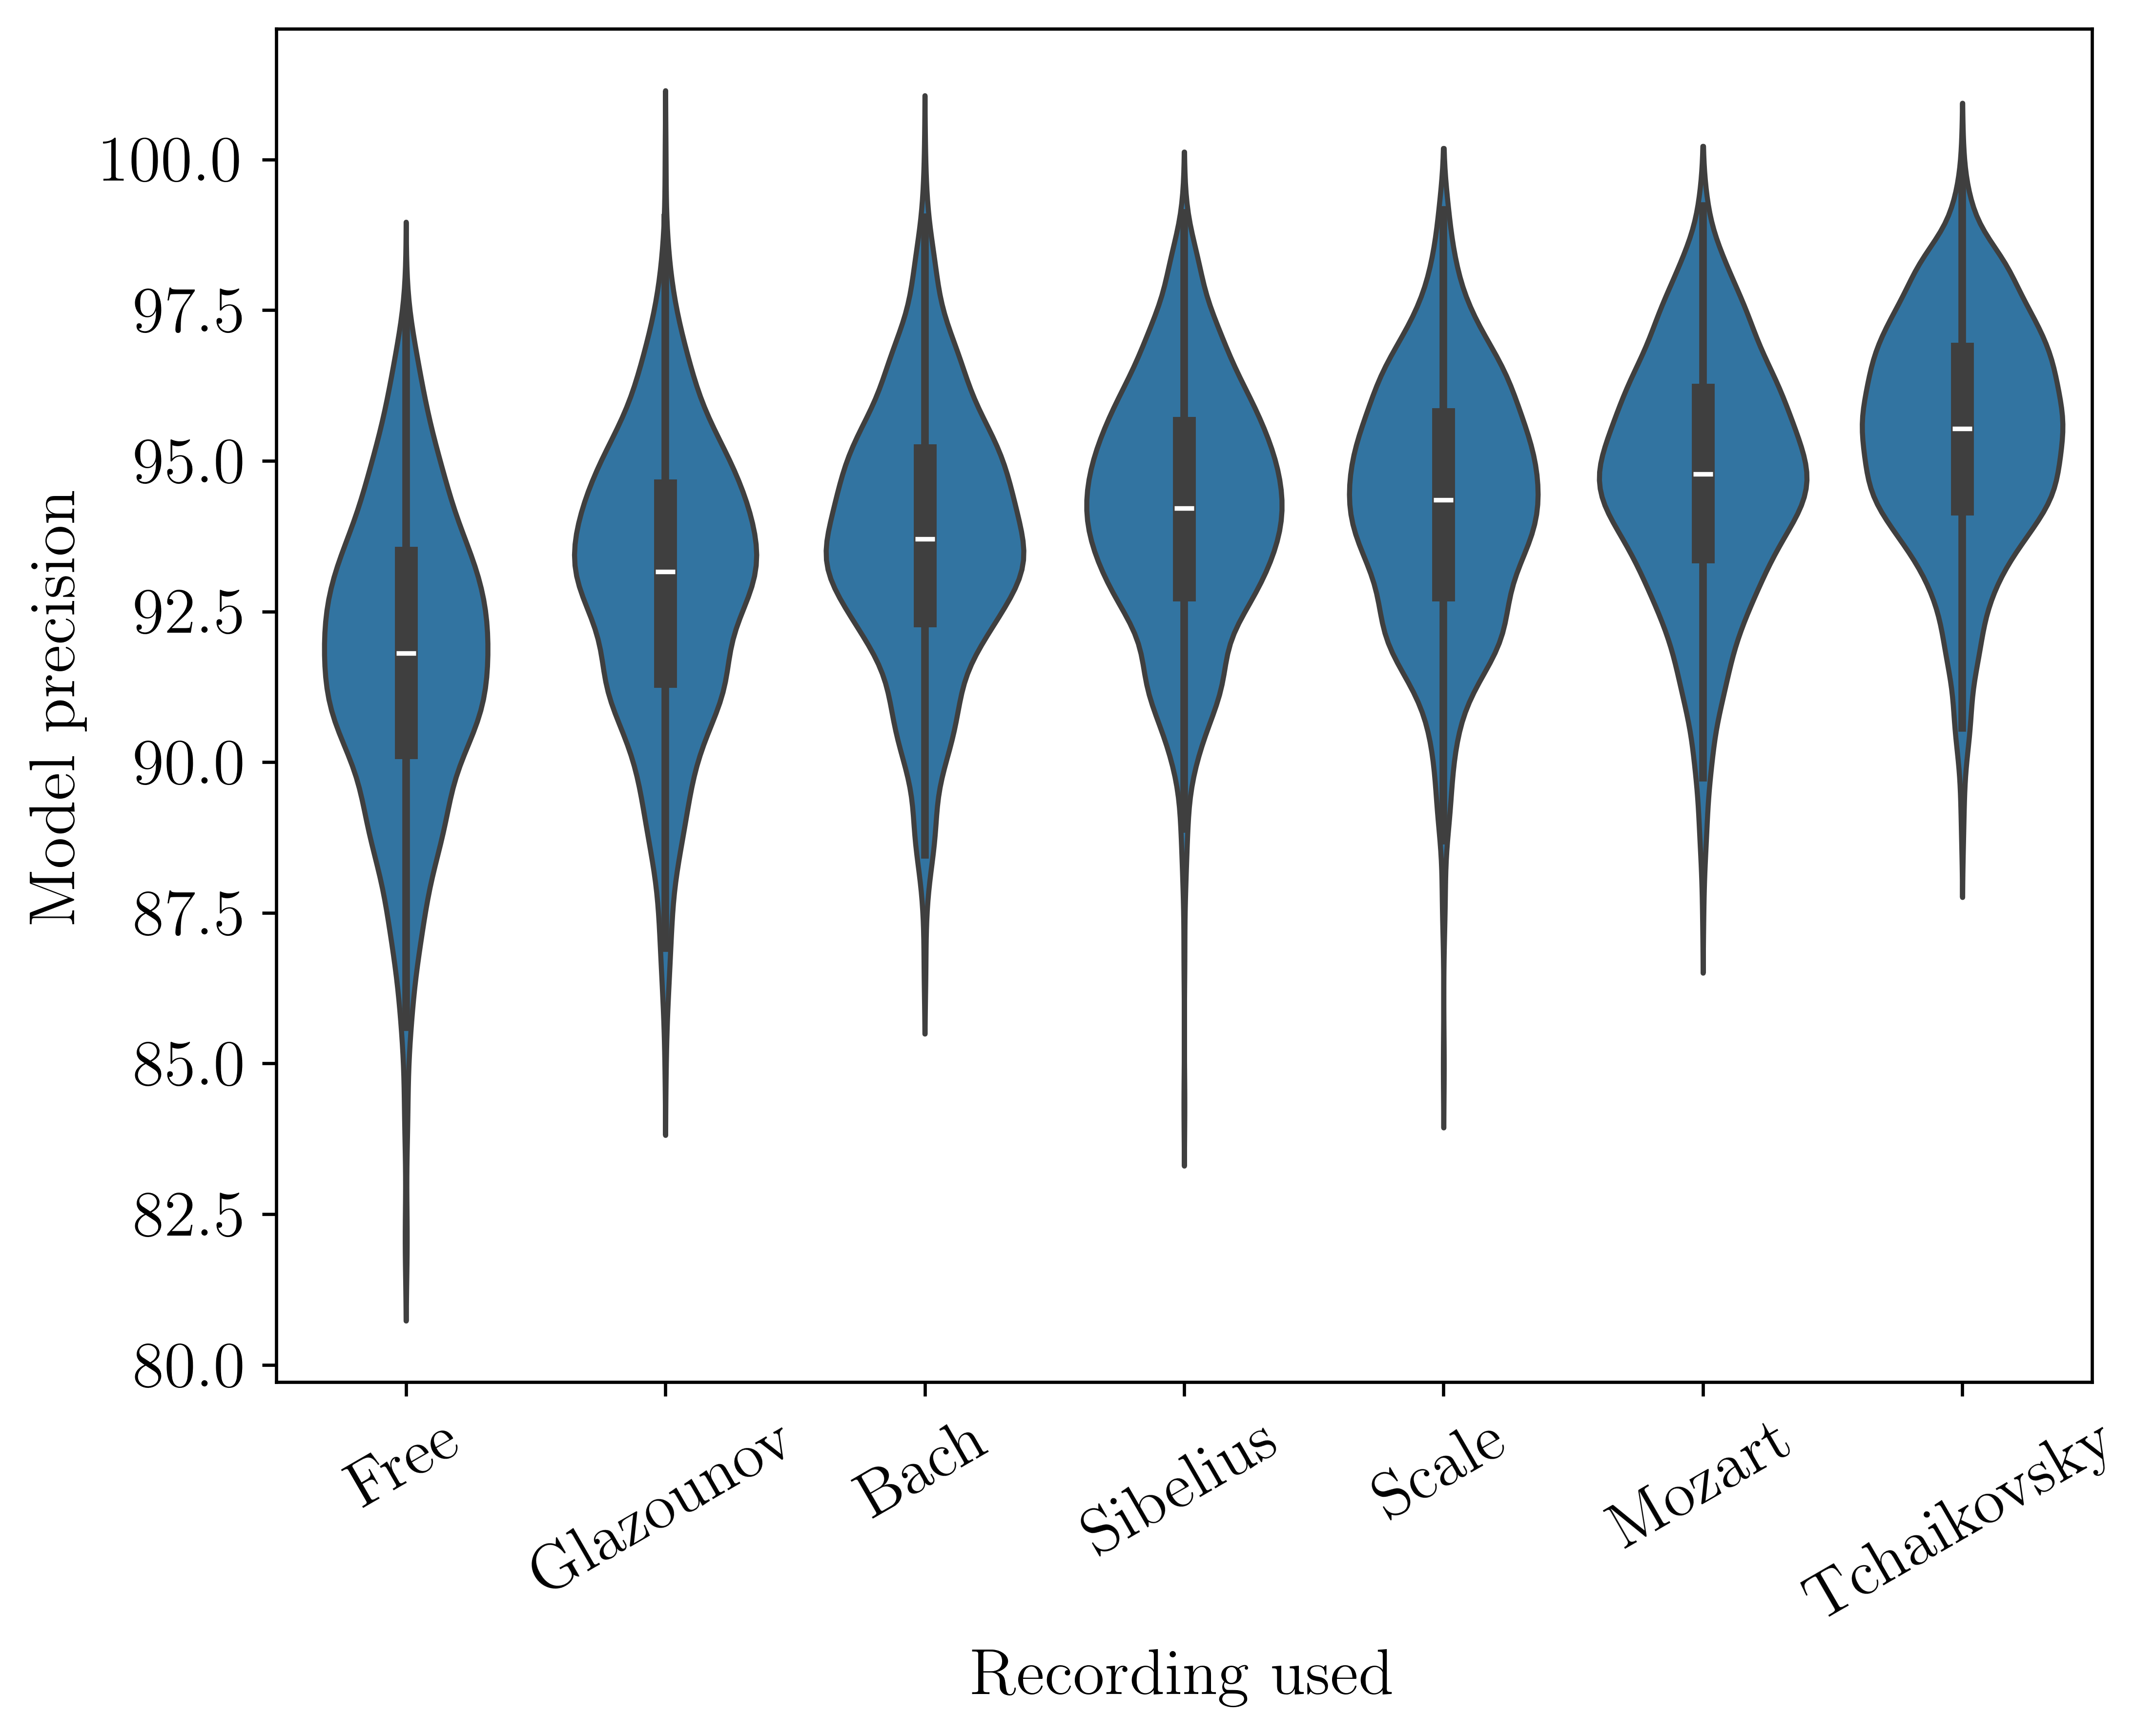

In [47]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))

scores.replace('tchai', 'Tchaikovsky', inplace=True)
scores.replace('gamme', 'Scale', inplace=True)
scores.replace('mozart', 'Mozart', inplace=True)
scores.replace('glazounov', 'Glazounov', inplace=True)
scores.replace('bach', 'Bach', inplace=True)
scores.replace('sibelius', 'Sibelius', inplace=True)
scores.replace('free', 'Free', inplace=True)

order = scores.groupby(by=['extract'])['score'].median().sort_values().index

sns.violinplot(x='extract', y='score', data=scores, order=order)
ax.set_xlabel('Recording used')
ax.set_ylabel('Model precision')
ax.tick_params(axis='x', rotation=30)
plt.savefig('../reports/figures/precision-vs-extract.png', dpi=600, bbox_inches='tight')
